### Imports and Setup

In [177]:
#Imports
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import itertools
from sklearn.cluster import AgglomerativeClustering as SingleLinkage
from sklearn.metrics import silhouette_score
from scipy.stats import multivariate_t
import pandas as pd
from matplotlib.offsetbox import AnchoredText
from scipy.spatial.distance import pdist,cdist, squareform
from sklearn.utils import check_random_state
import random

seed  = 5
random.seed(seed)
np.random.seed(seed)
rng = check_random_state(seed)

### Dataset Creation Functions

In [178]:
def TwoGuassians(NumPointsInCluster=100 ,distance=2, dim=100, power=-3/4, c=1.0):
    u = np.zeros(dim)
    u[0] = distance
    
    X = np.zeros((2*NumPointsInCluster, dim))
    X[0:NumPointsInCluster] = np.random.multivariate_normal(np.zeros(dim),  np.multiply(c,np.power(dim,power)*np.identity(dim)), size = NumPointsInCluster)
    X[NumPointsInCluster:2*NumPointsInCluster] = np.random.multivariate_normal(u,  np.multiply(c,np.power(dim,power)*np.identity(dim)), size = NumPointsInCluster)
    
    return X

In [179]:
def TwoT_Student(NumPointsInCluster=100 ,distance=2, dim=100, power=-3/4, c=1.0, degrees=2):
    u = np.zeros(dim)
    u[0] = distance
    
    X = np.zeros((2*NumPointsInCluster, dim))
    X[0:NumPointsInCluster] = multivariate_t.rvs(np.zeros(dim), np.multiply(c,np.power(dim,power)*np.identity(dim)), df=degrees, size=NumPointsInCluster)
    X[NumPointsInCluster:2*NumPointsInCluster] = multivariate_t.rvs(u, np.multiply(c,np.power(dim,power)*np.identity(dim)), df=degrees, size=NumPointsInCluster)
    
    return X

In [180]:
#Takes in a d-dimensional dataset X and appends guassian noise
def PlusGuassian(X, dimension):
    #X_new = np.zeros((X.shape[0], X.shape[1]+dimension))
    #X_new[:,0:X.shape[1]-1] = np.add(X_new[:,0:X.shape[1]-1], X)# = np.copy(X)
    #print(X_new)
    #print(X_new[:,X.shape[1]:dimension+X.shape[1]].shape)
    #X_new[:,X.shape[1]:dimension+X.shape[1]] = 
    Noise = np.random.multivariate_normal(np.zeros(dimension),  np.power(dimension,-3/4)*np.identity(dimension), size = X.shape[0])
    
    return np.concatenate((X, Noise), axis=1)

In [181]:
#n needs to be divisible by 25
def makeAmongUS(n, dim):
    
    Xs = np.zeros((n, dim))

    ptsPerShare = n/12.5

    n1 = int(3*ptsPerShare)
    n2 = int(2*ptsPerShare)
    n3 = int(1.5*ptsPerShare)
    n4 = int(1*ptsPerShare)
    n5 = int(1*ptsPerShare)
    n6 = int(1*ptsPerShare)
    n7 = int(2*ptsPerShare)


    #part 1
    pts = np.linspace(0,2*np.pi, num=n1)
    dataX = 0.5*np.cos(pts)+0.3
    dataY = 0.25*np.sin(pts)+1

    Xs[:n1,0]=dataX 
    Xs[:n1,1]=dataY

    #part2 
    pts = np.linspace(0.116, 1, num=n2)
    dataX = 0.5*np.cos(np.pi*pts)
    dataY = 0.66*np.sin(np.pi*pts)+1

    Xs[n1:n1+n2,0]=dataX 
    Xs[n1:n1+n2,1]=dataY

    #part3 
    pts = np.linspace(0, 1, num=n3)
    dataX = -0.5*np.ones(pts.shape)
    dataY = pts

    Xs[n1+n2:n1+n2+n3,0]=dataX 
    Xs[n1+n2:n1+n2+n3,1]=dataY

    #part4 
    pts = np.linspace(0, 0.76, num=n4)
    dataX = 0.47*np.ones(pts.shape)
    dataY = pts

    Xs[n1+n2+n3:n1+n2+n3+n4,0]=dataX 
    Xs[n1+n2+n3:n1+n2+n3+n4,1]=dataY

    #part5
    pts = np.linspace(0, 1, num=n5)
    dataX = 0.25*np.cos(np.pi*pts)-0.25
    dataY = -0.25*np.sin(np.pi*pts)

    Xs[n1+n2+n3+n4:n1+n2+n3+n4+n5,0]=dataX 
    Xs[n1+n2+n3+n4:n1+n2+n3+n4+n5,1]=dataY

    #part6
    pts = np.linspace(0, 1, num=n6)
    dataX = (0.47/2)*np.cos(np.pi*pts)+(0.47/2)
    dataY = -(0.47/2)*np.sin(np.pi*pts)

    Xs[n1+n2+n3+n4+n5:n1+n2+n3+n4+n5+n6,0]=dataX 
    Xs[n1+n2+n3+n4+n5:n1+n2+n3+n4+n5+n6,1]=dataY

    #part7
    pts = np.linspace(0, 1, num=n7)
    dataX = 0.25*np.cos(np.pi*pts+np.pi/2)-0.5
    dataY = 0.5*np.sin(np.pi*pts+np.pi/2)+0.5

    Xs[n1+n2+n3+n4+n5+n6:n1+n2+n3+n4+n5+n6+n7,0]=dataX 
    Xs[n1+n2+n3+n4+n5+n6:n1+n2+n3+n4+n5+n6+n7,1]=dataY


    plt.scatter(Xs[:,0], Xs[:,1])
    plt.show()
    
    return Xs

In [182]:
#Double Centering Matrix
def generateH(n):
    return np.eye(n) - np.ones((n, n)) / n

#Takes in distance matrix and returns gram matrix
def gramArray(D):
    H = generateH(D.shape[0])
    return -0.5 * H @ D @ H

#Creates D^2 matrix given gram matrix X in R^(n x n) where n is number of points
def distanceSquaredArray2(XtX):
    n = XtX.shape[0]
    D_squared = np.zeros((n,n))
    for i,j in itertools.product(range(0,n),range(0,n)):
        D_squared[i][j] = XtX[i][i] - 2*XtX[i][j] + XtX[j][j]
    return D_squared

In [183]:
def makeEsimplex(X, eps):
    if eps <= 0 or eps>= 1:
        print('Failure: Epsilon not in (0,1)')
        return X
    
    D = distanceSquaredArray2(np.matmul(X, np.transpose(X)))
    Dmin = np.min(D+np.max(D)*np.identity(D.shape[0]))
    Dmax = np.max(D)
    
    #Handle case where X is already an eps-simplex
    if Dmin/Dmax > (1-eps)/(1+eps):
        Xnew = np.multiply((1+eps)/Dmax, X)
        
        #Double check work
        D = distanceSquaredArray2(np.matmul(Xnew, np.transpose(Xnew)))
        Dmin = np.min(D+np.max(D)*np.identity(D.shape[0]))
        Dmax = np.max(D)
        print('Dmax = '+str(Dmax)+ ' Dmin = '+ str(Dmin))
        
        return Xnew
    
    #Create eps-simplex distance matrix
    A = (1/(2*eps))*((1-eps)*Dmax - (1+eps)*Dmin)
    B = (2*eps)/(Dmax-Dmin)
    
    D = B*(D + np.multiply(A,(np.ones(np.shape(D))-np.identity(D[0].shape[0]))))
    
    Dmin = np.min(D+np.max(D)*np.identity(D.shape[0]))
    Dmax = np.max(D)
    print('Dmax = '+str(Dmax)+ ' Dmin = '+ str(Dmin))
    
    n = D.shape[0]
    
    #Centering matrix
    H = np.eye(n) - np.ones((n, n)) / n

    #Computing inner product matrix
    B = -0.5 * H @ D @ H

    #Eigendecomposition
    eigvals, eigvecs = np.linalg.eigh(B)
    
    #Deal with numerical issues where the smallest eigenvalue is just barely negative
    if np.min(eigvals) < 0:
        B = B-np.min(eigvals)
    
    Xnew = np.linalg.cholesky(B)
    
    return Xnew



#Give epsilon simplex distance matrix
def makeEsimplexDistance(X, eps):
    if eps <= 0 or eps>= 1:
        print('Failure: Epsilon not in (0,1)')
        return X
    
    D = distanceSquaredArray2(np.matmul(X, np.transpose(X)))
    Dmin = np.min(D+np.max(D)*np.identity(D.shape[0]))
    Dmax = np.max(D)
    
    #Handle case where X is already an eps-simplex
    if Dmin/Dmax > (1-eps)/(1+eps):
        Xnew = np.multiply((1+eps)/Dmax, X)
        
        #Double check work
        D = distanceSquaredArray2(np.matmul(Xnew, np.transpose(Xnew)))
        Dmin = np.min(D+np.max(D)*np.identity(D.shape[0]))
        Dmax = np.max(D)
        print('Dmax = '+str(Dmax)+ ' Dmin = '+ str(Dmin))
        
        return D
    
    #Create eps-simplex distance matrix
    A = (1/(2*eps))*((1-eps)*Dmax - (1+eps)*Dmin)
    B = (2*eps)/(Dmax-Dmin)
    
    print('A = ' + str(A) + ', B = '+ str(B))
    
    D = B*(D + np.multiply(A,(np.ones(np.shape(D))-np.identity(D[0].shape[0]))))
    
    Dmin = np.min(D+np.max(D)*np.identity(D.shape[0]))
    Dmax = np.max(D)
    print('Dmax = '+str(Dmax)+ ' Dmin = '+ str(Dmin))
    
    
    return D

#Give epsilon simplex distance matrix
def makeEsimplexDistance(X, C, decimals = 8):
    
    D = distanceSquaredArray2(np.matmul(X, np.transpose(X))) 
    
    if C < 0 or C>1:
        print('Failure: C out of bounds.')
        return D
    
    A = np.round(C/np.max(D), decimals = decimals)
    
    D = A*D + (np.ones(np.shape(D))-np.identity(D[0].shape[0]))
    
    return D

### Figure Making

#### Interplay with concentration of meaasure

In [184]:
n=100
from tqdm import tqdm
''' This one works pretty well
dimensions = [100, 500, 1000, 3000]
powers=[-0.75, -0.75, -0.75, -0.75]
C=[0.50, 0.75, 1.0, 1.75]
'''

dimensions = [250, 500, 1000, 2000, 4000]
powers=[-0.75, -0.75, -0.75, -0.75, -0.75]
C=[0.70, 0.75, 0.90, 1.15, 1.40]

Ds = dimensions.copy()
Xs = dimensions.copy()
for i in tqdm(range(len(dimensions))):
    X = TwoGuassians(NumPointsInCluster=n ,distance=1, dim=dimensions[i], power=powers[i], c=C[i])
    Xs[i]=X
    Ds[i]=distanceSquaredArray2(np.matmul(X, np.transpose(X)))

 60%|██████    | 3/5 [00:04<00:02,  1.50s/it]


KeyboardInterrupt: 

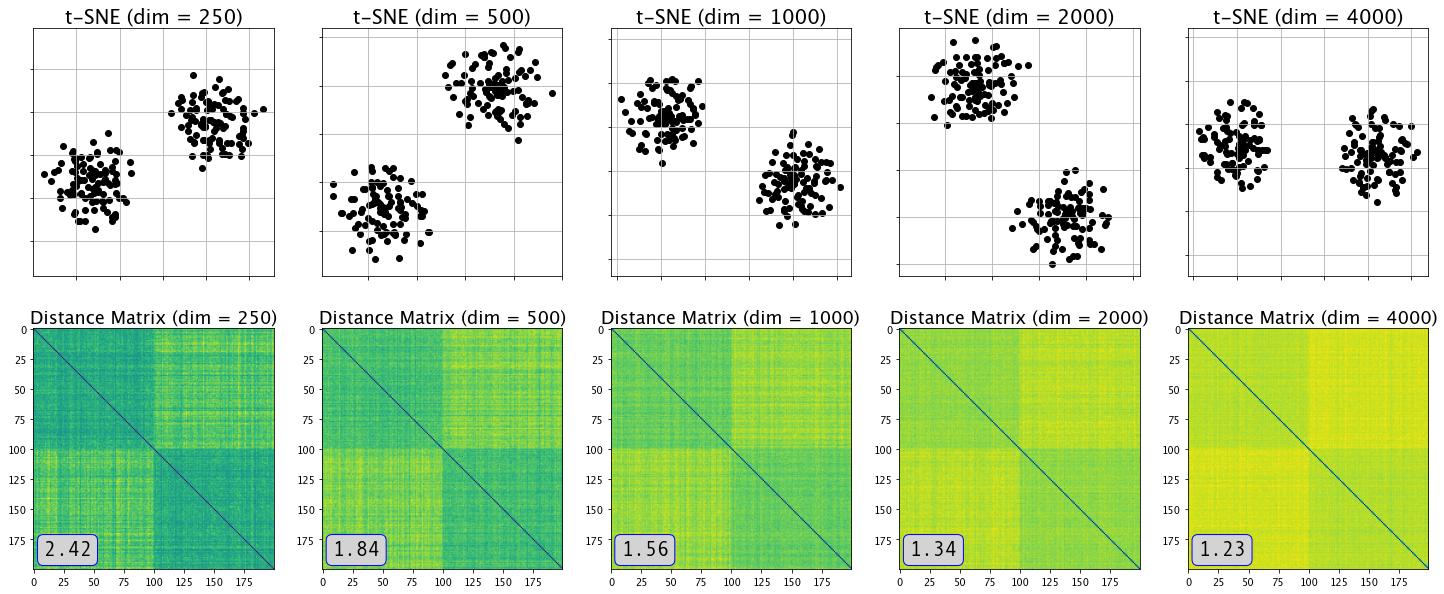

In [ ]:
#Creating Figure
fig, ax = plt.subplots(nrows=2, ncols=len(Ds))
fig.set_figwidth(5*len(dimensions))
fig.set_figheight(10)

#Running T-SNE
F = TSNE(learning_rate=100, perplexity=100, random_state=seed)

#Running Single Linkage on X
LinkageMethod = "ward"


for i in range(len(Ds)):
    #Plot t-SNE
    Y_features = F.fit_transform(Xs[i])
    Y_xaxis = Y_features[:,0]
    Y_yaxis = Y_features[:,1]
    
    ax[0, i].scatter(Y_xaxis, Y_yaxis, marker="o", color="black", alpha=1)
    ax[0, i].set_title('t-SNE (dim = '+ str(dimensions[i])+')', fontsize='20')
    #ax[0, i].set(xlabel='X', ylabel='Y')
    ax[0, i].axis('equal')
    
    #Plot Interpoint Distance Matrix
    Dmin = np.min(Ds[i]+np.max(Ds[i])*np.identity(Ds[i].shape[0]))
    Dmax = np.max(Ds[i])
    aspectRatio = Dmax/Dmin
    
    ASS = silhouette_score(Xs[i], np.concatenate((np.ones(n),np.zeros(n)))) #returns average silhouette score
    
    ax[1, i].imshow(Ds[i])
    ax[1, i].set_title('Distance Matrix (dim = '+ str(dimensions[i])+')', fontsize='18')
    
    ax[1, i].text(8, 176, str(np.round(aspectRatio,decimals=2)), verticalalignment='top', fontsize=20, weight='light', 
                  family='monospace', bbox = {'facecolor': 'lightgrey', 'alpha': 1, 'boxstyle': "round,pad=0.3", 'ec': 'b'})
    #ax[1, i].text(0.05, 0.05, str(np.round(aspectRatio,decimals=2)),transform=ax[1,i].transAxes,
              #bbox=dict(facecolor='lightgrey', edgecolor='black', boxstyle='round,pad=0.3'), fontsize=25, ha='left', va='bottom')
    
    ax[0, i].grid('on')
    ax[0, i].axis('equal')
    ax[0, i].set_xticklabels([])
    ax[0, i].set_yticklabels([])

fig.savefig('visuals/perturbation/amongus.png')

#### Eps-close Input, Different Output

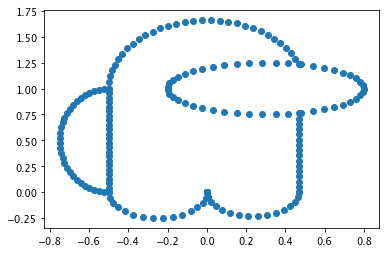

In [ ]:
n=200


dimensions = [200, 200, 200, 200, 200]
#dimensions = [400, 400, 400, 400, 400]

powers=[-0.75, -0.75, -0.75, -0.75, -0.75]
C=[0.70, 0.75, 0.90, 1.15, 1.40]


Xs = dimensions.copy()



#One Clusters
c = 0.1
power = -0.9
Xs[0] = np.random.multivariate_normal(np.zeros(dimensions[1]), c* np.power(dimensions[1],power)*np.identity(dimensions[1]), size = n)


#Two Clusters
distance = 4.5

Xs[1] = TwoGuassians(NumPointsInCluster=int(n/2) ,distance=distance, dim=dimensions[0])

#Four Clusters
distance = 4.5

NumPointsInCluster = int(n/4)
u = np.zeros(dimensions[2])

X = np.zeros((n, dimensions[2]))
X[0:NumPointsInCluster] = np.random.multivariate_normal(u, np.power(dimensions[2],-0.75)*np.identity(dimensions[2]), size = NumPointsInCluster)
u[0]=distance
X[NumPointsInCluster:2*NumPointsInCluster] = np.random.multivariate_normal(u, np.power(dimensions[2],-0.75)*np.identity(dimensions[2]), size = NumPointsInCluster)
u[1]=distance
X[2*NumPointsInCluster:3*NumPointsInCluster] = np.random.multivariate_normal(u, np.power(dimensions[2],-0.75)*np.identity(dimensions[2]), size = NumPointsInCluster)
u[0]=0
X[3*NumPointsInCluster:n] = np.random.multivariate_normal(u, np.power(dimensions[2],-0.75)*np.identity(dimensions[2]), size = NumPointsInCluster)
Xs[2] = X


#A circle
pts = np.linspace(0,2*np.pi, num=n)
dataX = np.cos(pts)
dataY = np.sin(pts)

Xs[3] = np.zeros((n, dimensions[1]))
Xs[3][:,0]=dataX 
Xs[3][:,1]=dataY


#Among us?
Xs[4] = makeAmongUS(n, dimensions[4])

In [ ]:
#Make the data into epsilon simplexes

C= 0.008
decimals = 4 #note that 4 works pertty well.


Ds = dimensions.copy()

#Ds[0] = distanceSquaredArray2(np.matmul(Xs[0], np.transpose(Xs[0])))
#Ds[0] = Ds[0]/np.min(Ds[0]+np.max(Ds[0])*np.identity(Ds[0].shape[0]))
Ds[0] = makeEsimplexDistance(Xs[0], C, decimals=decimals)
Ds[1] = makeEsimplexDistance(Xs[1], C, decimals = decimals)
Ds[2] = makeEsimplexDistance(Xs[2], C, decimals = decimals)
Ds[3] = makeEsimplexDistance(Xs[3], C, decimals = decimals)
Ds[4] = makeEsimplexDistance(Xs[4], C, decimals = decimals)

maxval = -1
minval = 10
for i in range(len(Ds)):
    #Ds[i] = np.round(Ds[i], decimals = 4)
    maxplace = np.max(Ds[i])
    minplace = np.min(Ds[i]+np.max(Ds[i])*np.identity(Ds[i].shape[0]))
    print(str(i)+" has Dmax = " + str(maxplace) + " and Dmin = " + str(minplace))
    maxval = np.max([maxplace, maxval])
    minval = np.min([minplace, minval])

eps = np.max([maxval/minval - 1.0, 1.0 - minval/maxval])  
print('Eps = '+ str(maxval)+' / '+str(minval)+' = ' +str(eps))

0 has Dmax = 1.0079975616948618 and Dmin = 1.0036900017024908
1 has Dmax = 1.006779097237391 and Dmin = 1.000991146287809
2 has Dmax = 1.00572443583978 and Dmin = 1.0004844218575353
3 has Dmax = 1.0079995015580707 and Dmin = 1.0
4 has Dmax = 1.0078495974929116 and Dmin = 1.0
Eps = 1.0079995015580707 / 1.0 = 0.00799950155807072


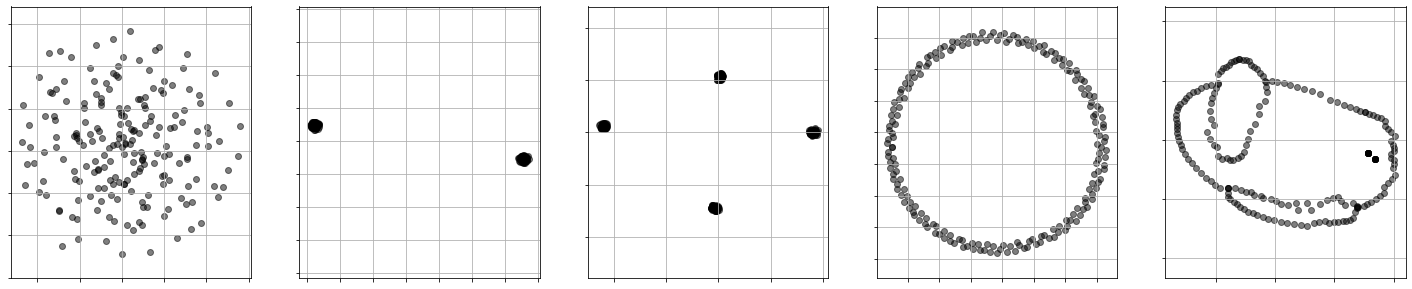

In [ ]:
### Running t-SNE w/o PCA ###
#Creating Figure
fig, ax = plt.subplots(nrows=1, ncols=len(Ds))
fig.set_figwidth(len(Ds)*5)
fig.set_figheight(5)

#Setting perplexities
perps=[30, 100, 50, 30, 80]


for i in range(len(Ds)):
        
        #Running T-SNE
        F = TSNE(learning_rate=70, perplexity=perps[i], random_state=seed)#, init='random',metric='precomputed')
        
        #Plot t-SNE
        Y_features = F.fit_transform(Ds[i])
        Y_xaxis = Y_features[:,0]
        Y_yaxis = Y_features[:,1]

        ax[i].scatter(Y_xaxis, Y_yaxis, marker="o", color="black", alpha=0.5)
        
        '''
        if i == 0:
            ax[i].set(xlabel='X', ylabel='Y', title='t-SNE Visualization of One Cluster')
        elif i == 1:
            ax[i].set(xlabel='X', ylabel='Y', title='t-SNE Visualization of Two Clusters')
        elif i == 2:
            ax[i].set(xlabel='X', ylabel='Y', title='t-SNE Visualization of Four Clusters')
        elif i == 3:
            ax[i].set(xlabel='X', ylabel='Y', title='t-SNE Visualization of a Circle')
        '''
            
        ax[i].grid('on')
        ax[i].axis('equal')
        ax[i].set_xticklabels([])
        ax[i].set_yticklabels([])

In [ ]:
eps=np.round(eps, decimals=3)
fig.savefig('visuals/perturbation/amongus.png')

#### The Poison Point

In [ ]:
n=100

dimensions = [2000, 2000]

Ds = dimensions.copy()
Xs = dimensions.copy()
for i in range(len(dimensions)):
    X = TwoGuassians(NumPointsInCluster=n ,distance=1, dim=dimensions[i])
    Xs[i]=X
    Ds[i]=distanceSquaredArray2(np.matmul(X, np.transpose(X)))

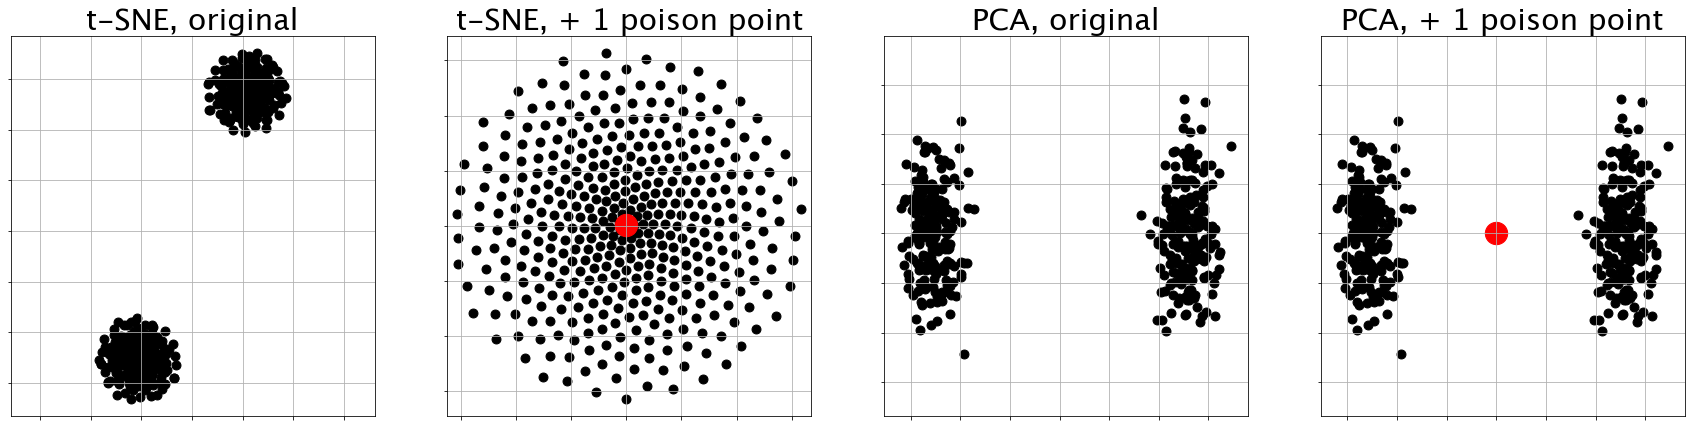

In [ ]:
tsne = TSNE(learning_rate=100,random_state=seed, method='exact')
pca = PCA(n_components=2,random_state=seed)
X = TwoGuassians(NumPointsInCluster=200, distance=1, dim=2000)
X1 = np.concatenate((X, np.array( [  np.mean(X, axis=0)  ])), axis=0)

X_tsne0 = tsne.fit_transform(X)
X_tsne1 = tsne.fit_transform(X1)

X_pca0 = pca.fit_transform(X)
X_pca1 = pca.fit_transform(X1)


fig, axs = plt.subplots(1,4, figsize=(30,7))
n = len(X)

for i in range(4):
    axs[i].grid('on')
    axs[i].axis('equal')
    axs[i].set_xticklabels([])
    axs[i].set_yticklabels([])

axs[0].scatter(X_tsne0[:,0],X_tsne0[:,1],  s=80,color='black')
axs[0].set_title('t-SNE, original', fontsize=30)

axs[1].scatter(X_tsne1[:-1,0],X_tsne1[:-1,1], s=80, color='black')
axs[1].scatter(X_tsne1[-1,0],X_tsne1[-1,1],  s=500, color='red')
axs[1].set_title('t-SNE, + 1 poison point', fontsize=30)


axs[2].scatter(X_pca0[:,0],X_pca0[:,1],  s=80,color='black')
axs[2].set_title('PCA, original', fontsize=30)

axs[3].scatter(X_pca1[:-1,0],X_pca1[:-1,1], s=80, color='black')
axs[3].scatter(X_pca1[-1,0],X_pca1[-1,1],  s=500, color='red')
axs[3].set_title('PCA, + 1 poison point', fontsize=30)


plt.savefig('visuals/outlier_new/one_pt_perturb.png', bbox_inches='tight' )

In [194]:
reruns = []
perps = []

for i in range(8):

    u = random.uniform(30, 100)
    tsne = TSNE(learning_rate=100,perplexity=u,method='exact',random_state=i)
    plot = tsne.fit_transform(X1) 
    reruns.append(plot)
    perps.append(u)


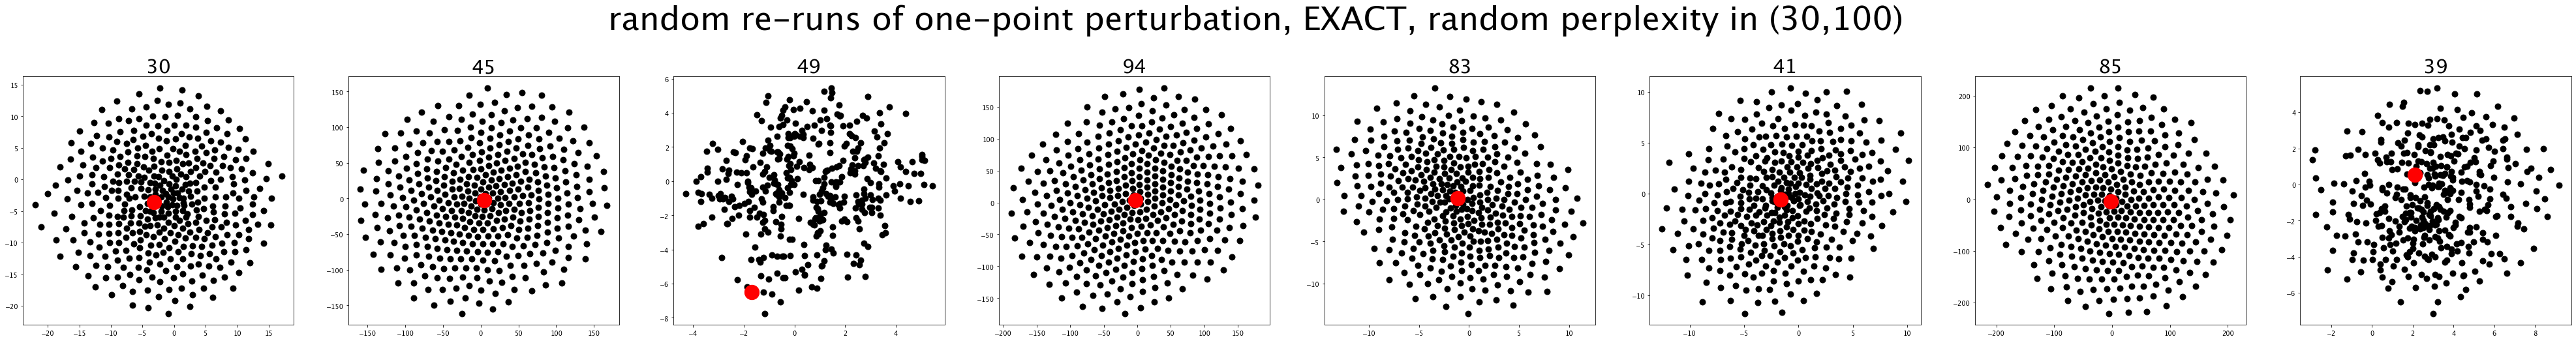

In [195]:
fig, axs = plt.subplots(1,8, figsize=(70,7))
for i in range(8):

    axs[i].set_title(str(int(perps[i])), fontsize=30)
    axs[i].scatter(reruns[i][:-1,0],reruns[i][:-1,1], s=80, color='black')
    axs[i].scatter(reruns[i][-1,0],reruns[i][-1,1],  s=500, color='red')

plt.suptitle('random re-runs of one-point perturbation, EXACT, random perplexity in (30,100)', fontsize=50,  y=1.1)
plt.savefig('visuals/perturbation/one_pt_perturb_exact_perplexitychanging.png')